In [3]:
!pip install nltk

In [4]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 72.2 MB/s eta 0:00:00


In [5]:
!pip install requests

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
import requests
import fitz  # PyMuPDF
from io import BytesIO
import numpy as np
import pandas as pd

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [ ]:
train_data_path = '/content/drive/MyDrive/NLP Project/data/mle-1-assign-dataset - train_data.csv'
test_data_path = '/content/drive/MyDrive/NLP Project/data/mle-1-assign-dataset - test_data.csv'

## Data Cleaning

In [ ]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [ ]:
train_data = train_df.copy()
test_data = test_df.copy()

In [ ]:
# function for data cleaning
def data_cleaning(df):
  df.drop_duplicates(inplace=True)
  df.drop(df[df['datasheet_link'] == '-'].index,inplace=True)
  return df

In [ ]:
# Train data size
print('*'*50)
print('Original Train Data size : ',len(train_data))
clean_train_data = data_cleaning(train_df).copy()
print('Cleaned Train Data size : ',len(clean_train_data))

print('*'*50)

# Test data size
print('Original Test Data size : ',len(test_data))
clean_test_data = data_cleaning(test_df).copy()
print('Cleaned Test Data size : ',len(clean_test_data))
print('*'*50)

**************************************************
Original Train Data size :  1895
Cleaned Train Data size :  1197
**************************************************
Original Test Data size :  400
Cleaned Test Data size :  258
**************************************************


In [ ]:
# Visualization of our data before cleaning and after cleaning
print('*'*120)
train_values =  dict(train_data['target_col'].value_counts())
clean_train_values = dict(clean_train_data['target_col'].value_counts())
print('Orizinal data values of each labels in train data : ',train_values)
print('Cleaned data values of each labels in train data : ',clean_train_values)

print('*'*120)
test_values =  dict(test_data['target_col'].value_counts())
clean_test_values = dict(clean_test_data['target_col'].value_counts())
print('Orizinal data values of each labels in test data : ',test_values)
print('Cleaned data values of each labels in test data : ',clean_test_values)
print('*'*120)


************************************************************************************************************************
Orizinal data values of each labels in train data :  {'lighting': 500, 'fuses': 500, 'cable': 500, 'others': 395}
Cleaned data values of each labels in train data :  {'lighting': 500, 'others': 286, 'cable': 271, 'fuses': 140}
************************************************************************************************************************
Orizinal data values of each labels in test data :  {'others': 125, 'cable': 125, 'lighting': 100, 'fuses': 50}
Cleaned data values of each labels in test data :  {'lighting': 100, 'cable': 96, 'others': 39, 'fuses': 23}
************************************************************************************************************************


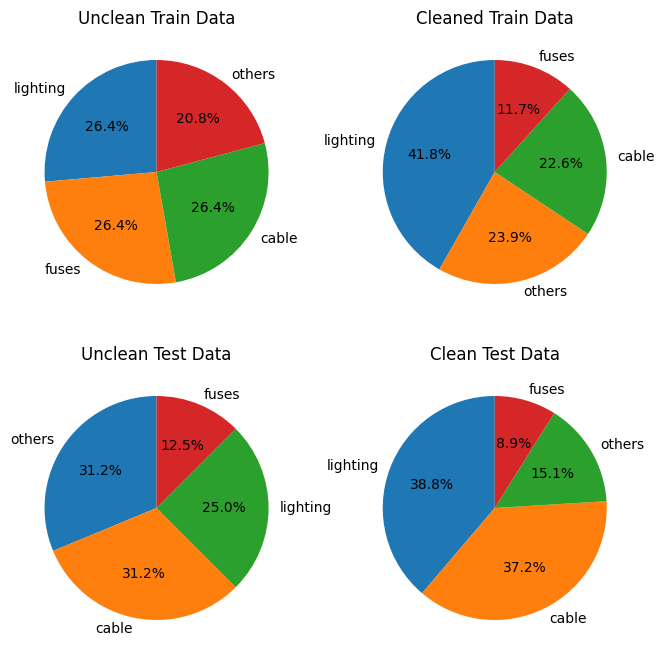

In [ ]:
import matplotlib.pyplot as plt

# Create subplots: 2 rows, 2 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

# Plot the first pie chart
ax1.pie(train_values.values(), labels=train_values.keys(), autopct='%1.1f%%', startangle=90)
ax1.set_title('Unclean Train Data')

# Plot the second pie chart
ax2.pie(clean_train_values.values(), labels=clean_train_values.keys(), autopct='%1.1f%%', startangle=90)
ax2.set_title('Cleaned Train Data')

# Plot the third pie chart
ax3.pie(test_values.values(), labels=test_values.keys(), autopct='%1.1f%%', startangle=90)
ax3.set_title('Unclean Test Data')

# Plot the fourth pie chart
ax4.pie(clean_test_values.values(), labels=clean_test_values.keys(), autopct='%1.1f%%', startangle=90)
ax4.set_title('Clean Test Data')

# Display the plots
plt.show()

## Text Extraction and Preprocessing

In [33]:
class customdata:
  def __init__(self):
    self.pdf_url = ''
    self.text = ''

# Extract text from PDF File link
  def extract_text_from_pdf(self,pdf_url):
    self.pdf_url = pdf_url
    try:
        # Download the PDF
        response = requests.get(self.pdf_url, timeout=5)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Read the PDF content
        pdf_content = BytesIO(response.content)
        pdf_document = fitz.open(stream=pdf_content, filetype="pdf")

        # Extract text from each page
        text = ""
        for page_num in range(len(pdf_document)):
            page = pdf_document.load_page(page_num)
            text += page.get_text()

        return text

    except Exception as e:
        print(f"Error processing {pdf_url}: {e}")
        return ""

# Text pre processing
  def preprocess_text(self,text):
    self.text = text
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    self.text = self.text.lower()

    # Remove punctuation and special characters
    self.text = re.sub(r'[^0-9a-zA-Z\s]', '', self.text)

    tokens = word_tokenize(self.text)
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    processed_text = ' '.join(processed_tokens)

    return processed_text


In [ ]:
def data_frame(df):
  data_columns = ['text','target']
  new_df = pd.DataFrame(columns=data_columns)
  obj = customdata()

  for index, row in df.iterrows():
    url = row['datasheet_link']
    target = row['target_col']
    pdf_text = obj.extract_text_from_pdf(url)
    if pdf_text != '':
      preprocess_text = obj.preprocess_text(pdf_text)
      print(index,preprocess_text)
      new_row = pd.DataFrame({'text':[preprocess_text],'target': [target]})
      new_df = pd.concat([new_df,new_row], ignore_index=True)
    else:
      continue

  return new_df


In [ ]:
test = data_frame(clean_test_data).copy()

0 awl01 specification material machined aluminum stainless steel fastener finish micro brushed clear coat fabrication assembly mounting new construction mini jbox lumenart remodel 4 square jbox round plaster ring octagon box order optional asc canopy electrical etl indoor damp location listed led lamp lumenart triac dimming ordering logic use matrix order complete fixture fixture lamping voltage 120v 45 asc canopy lumenart ltd 3333 w 47th st chicago il 60632 phone 7732540744 fax 7732540767 wwwlumenartcom option awl01 4w led 120v awl01 4w led 400lm optional asc canopy mini jbox lumenart 375 375 4 188 mc 4 45 45 awl01 awl01 asc frost cobalt blue amber glass
1 rdc series specification construction fabric laminated self extin guishing vinyl transparent fire retardant applied fabrica tion 40 standard fabric choice lumenarts standard material selection subject change based supplier availability common fo material manufac turers stock long period time change discontinue material without notic

In [ ]:
train = data_frame(clean_train_data).copy()

0 ef400 system ef408b die cast cylindrical light unit spotlight 315 diameter cylinder 125 x 125 arm articulation friction lock 90 x 90 head rotation friction lock die cast aluminum optical housing articulating arm allows greater aiming powder coat finish led source fieldchangeable optic cree valudim accepts 1 optical accessory electrical fieldreplaceable led driver dimmable mounting fabricated aluminum extension arm side channel magnetic mount designed ef400 ef4bns channel label suitable damp location catalog number type project small ef4b led 351 89 315 80 90 x 90 head rotation friction lock 960 244 power supply 2000 508 125 rotation friction lock magnetic mount 100 rotation friction lock 210 53 300 76 177 45 75 19 79 20 application view ef400 efbns channel shown magnetic mount arm detail specification headquarters 9200 deering avenue chatsworth ca 91311 telephone 8188851335 toll free 8558851335 fax 8185761335 2022 lf illumination llc reserve right change withdraw specification withou

In [ ]:
#train.to_csv('train.csv', index=False)

In [ ]:
#test.to_csv('test.csv', index=False)

## Modeling

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

In [19]:
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

In [9]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [10]:
X_train = train['text']
y_train = train['target']
X_test = test['text']
y_test = test['target']

In [13]:
pipeMNB = Pipeline([('tfidf', TfidfVectorizer()),('clf', MultinomialNB())])
pipeCNB = Pipeline([('tfidf', TfidfVectorizer()),('clf', ComplementNB())])
pipeSVC = Pipeline([('tfidf', TfidfVectorizer()),('clf', LinearSVC())])

In [20]:
pipeMNB.fit(X_train,y_train)
predictMNB = pipeMNB.predict(X_test)
print(f'MNB : {accuracy_score(y_test,predictMNB):.2f}')
pipeCNB.fit(X_train,y_train)
predictCNB = pipeCNB.predict(X_test)
print(f'CNB : {accuracy_score(y_test,predictCNB):.2f}')
pipeSVC.fit(X_train,y_train)
predictSVC = pipeSVC.predict(X_test)
print(f'SVC : {accuracy_score(y_test,predictSVC):.2f}')

MNB : 0.87
CNB : 0.87
SVC : 0.89


In [27]:
print(f'MNB:{classification_report(y_test,predictMNB)}')

MNB:              precision    recall  f1-score   support

       cable       1.00      0.96      0.98        46
       fuses       1.00      1.00      1.00        22
    lighting       0.76      1.00      0.87        65
      others       0.00      0.00      0.00        18

    accuracy                           0.87       151
   macro avg       0.69      0.74      0.71       151
weighted avg       0.78      0.87      0.82       151



In [28]:
print(f'CNB:{classification_report(y_test,predictCNB)}')

CNB:              precision    recall  f1-score   support

       cable       1.00      0.96      0.98        46
       fuses       1.00      1.00      1.00        22
    lighting       0.76      1.00      0.87        65
      others       0.00      0.00      0.00        18

    accuracy                           0.87       151
   macro avg       0.69      0.74      0.71       151
weighted avg       0.78      0.87      0.82       151



In [29]:
print(f'SVC:{classification_report(y_test,predictSVC)}')


SVC:              precision    recall  f1-score   support

       cable       1.00      1.00      1.00        46
       fuses       1.00      1.00      1.00        22
    lighting       0.79      1.00      0.88        65
      others       1.00      0.06      0.11        18

    accuracy                           0.89       151
   macro avg       0.95      0.76      0.75       151
weighted avg       0.91      0.89      0.84       151



## User Inputs

In [62]:
#url = 'https://catalog.belden.com/techdata/EN/1505A_techdata.pdf'                              # cable
#url_1 = 'https://lumenart.com/images/fabric/cyp/cyp_specs.pdf'                                 # lighting
#url_2 = 'https://www.belfuse.com/resources/datasheets/circuitprotection/ds-cp-rst-series.pdf'  # fuses

In [35]:
def user(url):
  obj = customdata()
  pdf_text = obj.extract_text_from_pdf(url)
  if pdf_text != '':
    preprocess_text = obj.preprocess_text(pdf_text)
    predictSVC = pipeSVC.predict([preprocess_text])

    return predictSVC
  else:
    return ['url Error Found']


In [61]:
user_input = input('Please Enter PDF Url : ')
predicetd_target = user(user_input)
print('Classifier result :',predicetd_target[0])

Please Enter PDF Url : https://catalog.belden.com/techdata/EN/1505A_techdata.pdf
Classifier result : cable
